# SOSE HEAT & SALT BUDGET

In [2]:
from dask_gateway import Gateway

g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [3]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.c95664fcf69d4a73a8a6170fb4e88ed2/status,


In [4]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import fsspec

## Open SOSE Dataset from the Cloud

In [5]:
fs = gcsfs.GCSFileSystem(requester_pays=True)

mapping = fs.get_mapper('gcs://pangeo-ecco-sose')

ds = xr.open_zarr(mapping, consolidated=True)

In [6]:
coordsr = ds.coords.to_dataset().reset_coords() #ds split into coords
dsr = ds.reset_coords(drop=True) #ds dropping coords so it just holds data variables
dsr

,Array,Chunk
Bytes,47.37 GiB,110.74 MiB
Shape,"(438, 42, 320, 2160)","(1, 42, 320, 2160)"
Count,2 Graph Layers,438 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,47.37 GiB,110.74 MiB
Shape,"(438, 42, 320, 2160)","(1, 42, 320, 2160)"
Count,2 Graph Layers,438 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


## New northern boundary | Visualize the ACC region you're going to ignore

In [7]:
#WG boundaries (65˚W, 30˚E; 80˚S, 57˚S)
#WG model's boundaries (-77.87497˚S, -57.041634˚S; 295.08334W, 30.083334E)
lower_lat = 0 #-77.87497
upper_lat = 125 #-57.041634
left_lon =  310 #51.75
right_lon = 880 #146.75

#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))
lat_range_u = dict(YG=slice(lower_lat, upper_lat+1))
lon_range_u = dict(XG=slice(left_lon, right_lon+1))

t = 30
Z = 0

coords = coordsr.roll(XC=700, XG=700, roll_coords=True).isel(**lat_range, **lon_range, **lat_range_u, **lon_range_u)
ds = dsr.roll(XC=700, XG=700, roll_coords=True).isel(**lat_range, **lon_range, **lat_range_u, **lon_range_u)

In [11]:
temp = ds.THETA[0,0].drop('XC')
mask = coords.drop('XC').hFacC[0] > 0

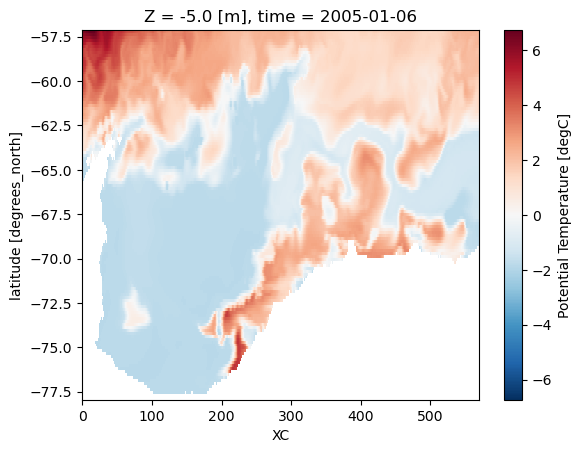

In [12]:
temp.where(mask).plot();

In [13]:
#mask out the acc in the corner
mask_acc = xr.ones_like(temp)

mask_acc[88:None, None:57] = 0
mask_acc[77:88, None:36] = 0
mask_acc[73:77, None:5] = 0

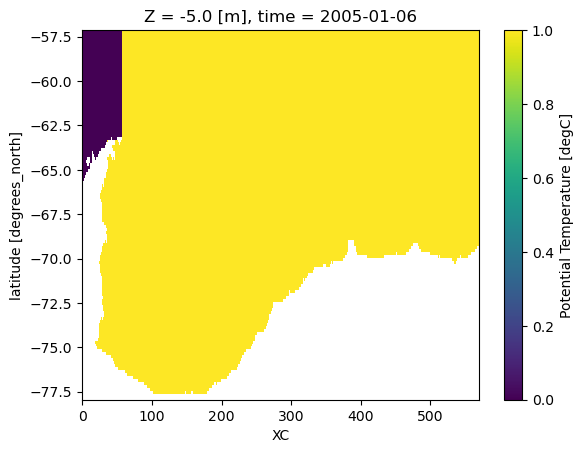

In [14]:
mask_acc.where(mask).plot();

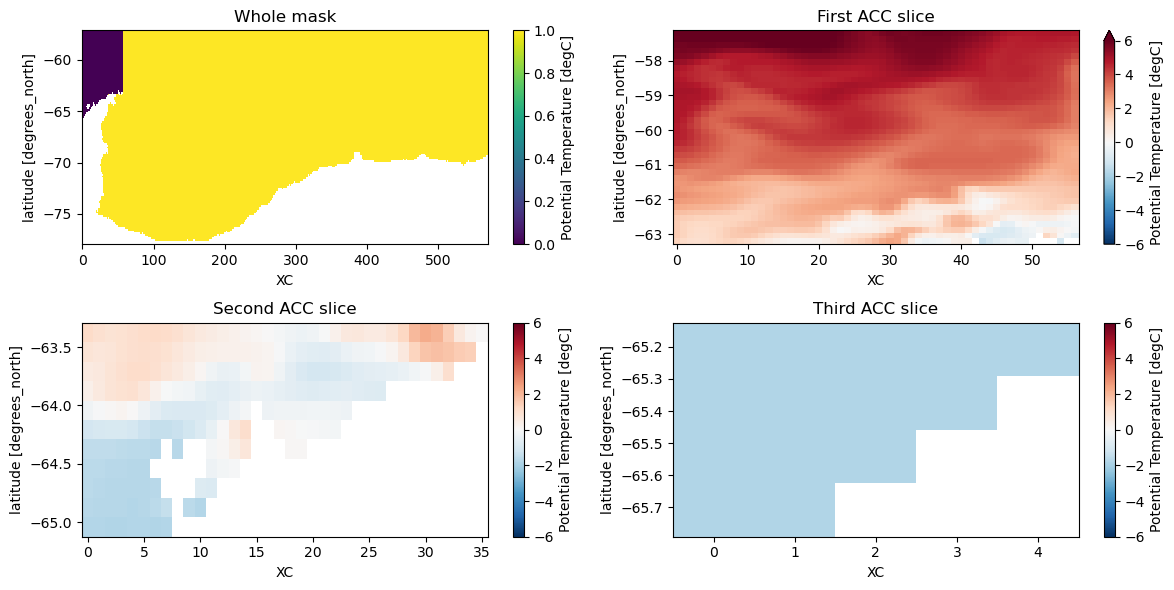

In [15]:
#visualize the 3 masks
fig, ax = plt.subplots(2,2, figsize=(12,6))

mask_acc.where(mask).plot(ax=ax[0,0])
ax[0,0].set_title('Whole mask')
temp.where(mask)[88:None, None:57].plot(ax=ax[0,1], cmap='RdBu_r', vmin=-6, vmax=6)
ax[0,1].set_title('First ACC slice')
temp.where(mask)[77:88, None:36].plot(ax=ax[1,0], cmap='RdBu_r', vmin=-6, vmax=6)
ax[1,0].set_title('Second ACC slice')
temp.where(mask)[73:77, None:5].plot(ax=ax[1,1], cmap='RdBu_r', vmin=-6, vmax=6)
ax[1,1].set_title('Third ACC slice')

plt.tight_layout();

In [16]:
assert ds.XG[0].values < ds.XC[0].values
assert ds.YG[0].values < ds.YC[0].values

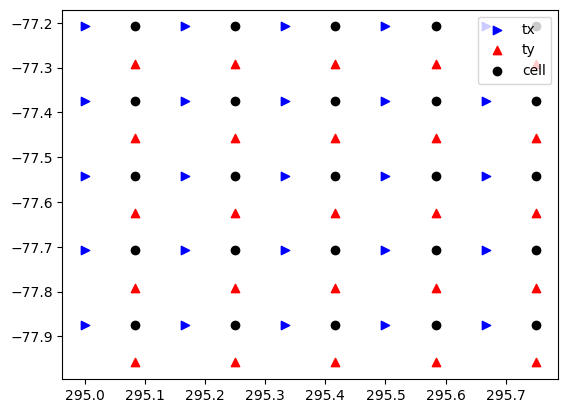

In [17]:
#visualize SOSE's grid
#first 5 grid pts
from matplotlib import pyplot as plt

tx_y, tx_x = xr.broadcast(*(ds[dim] for dim in ds.UVEL[0,0].dims))
ty_y, ty_x = xr.broadcast(*(ds[dim] for dim in ds.VVEL[0,0].dims))
cell_y, cell_x = xr.broadcast(ds.YC, ds.XC)

plt.scatter(tx_x[:5, :5], tx_y[:5, :5], color='b', label="tx", marker=">")
plt.scatter(ty_x[:5, :5], ty_y[:5, :5], color='r', label="ty", marker="^")
plt.scatter(cell_x[:5, :5], cell_y[:5, :5], color='k', label="cell", marker="o")
plt.legend(loc="upper right");

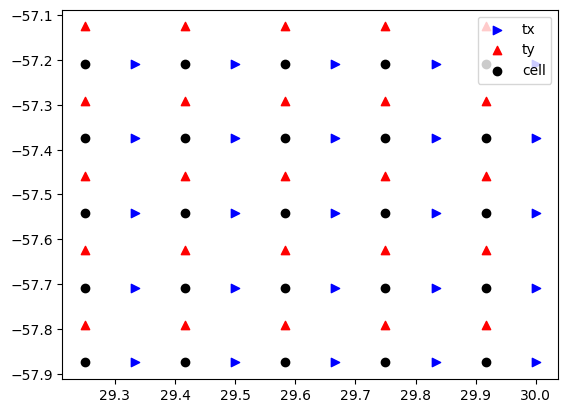

In [21]:
#visualize SOSE's grid
#last 5 grid pts
from matplotlib import pyplot as plt

tx_y, tx_x = xr.broadcast(*(ds[dim] for dim in ds.UVEL[0,0].dims))
ty_y, ty_x = xr.broadcast(*(ds[dim] for dim in ds.VVEL[0,0].dims))
cell_y, cell_x = xr.broadcast(ds.YC, ds.XC)

plt.scatter(tx_x[-5:, -5:], tx_y[-5:, -5:], color='b', label="tx", marker=">")
plt.scatter(ty_x[-5:, -5:], ty_y[-5:, -5:], color='r', label="ty", marker="^")
plt.scatter(cell_x[-5:, -5:], cell_y[-5:, -5:], color='k', label="cell", marker="o")
plt.legend(loc="upper right");

In [24]:
# Given upper right / lower left cell coordinates, construct the tx_trans and ty_trans sections that bound it

def box_budget(left_i, right_i, lower_j, upper_j,):
    """Function to compute box budget given any set of boundaries"""

    UTRANS = ds.UVEL * coords.dyG * coords.drF * coords.hFacW
    VTRANS = ds.VVEL * coords.dxG * coords.drF * coords.hFacS

    ty_upper = VTRANS.isel(XC=slice(left_i, right_i), YG=upper_j)
    ty_lower = VTRANS.isel(XC=slice(left_i, right_i), YG=lower_j)
    tx_right = UTRANS.isel(XG=right_i, YC=slice(lower_j, upper_j))
    tx_left = UTRANS.isel(XG=left_i, YC=slice(lower_j, upper_j))

    return (-ty_upper.mean('time').sum().values + ty_lower.mean('time').sum().values 
            - tx_right.mean('time').sum().values + tx_left.mean('time').sum().values)

In [25]:
box1 = box_budget(57, 570, 88, 125)
box2 = box_budget(36, 570, 77, 88)
box3 = box_budget(5, 570, 73, 77)
box4 = box_budget(0, 570, 0, 73)

residual = box1 + box2 + box3 + box4
(residual / 1e6)

-0.0437566015625

# Heat budget

In [8]:
#load in autoreload so you don't have to restart kernel everytime you want to run bb function
%load_ext autoreload

#Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

In [9]:
import bb

In [30]:
#testing imported bb module

#area-weighting velocities
UVEL = ds.UVEL * coords.dyG * coords.drF * coords.hFacW
VVEL = ds.VVEL * coords.dxG * coords.drF * coords.hFacS

#testing generalized function for transport

box1 = bb.box_budget(UVEL, VVEL, 57, 570, 88, 125)
box2 = bb.box_budget(UVEL, VVEL, 36, 570, 77, 88)
box3 = bb.box_budget(UVEL, VVEL, 5, 570, 73, 77)
box4 = bb.box_budget(UVEL, VVEL, 0, 570, 0, 73)

residual_vel = box1 + box2 + box3 + box4
(residual_vel.mean('time')/1e6).values

array(-0.04375143, dtype=float32)

In [31]:
print('box1: ', (box1.mean('time').values/1e6), 
      '\n box2: ', (box2.mean('time').values/1e6),
      '\n box2: ', (box3.mean('time').values/1e6),
      '\n box2: ', (box4.mean('time').values/1e6))

box1:  -0.019914447265625 
 box2:  -0.00539121337890625 
 box2:  -0.0018951885986328125 
 box2:  -0.016550578125


### Advection term

In [34]:
box1 = bb.box_budget(ds.ADVx_TH, ds.ADVy_TH, 57, 570, 88, 125)
box2 = bb.box_budget(ds.ADVx_TH, ds.ADVy_TH, 36, 570, 77, 88)
box3 = bb.box_budget(ds.ADVx_TH, ds.ADVy_TH,5, 570, 73, 77)
box4 = bb.box_budget(ds.ADVx_TH, ds.ADVy_TH,0, 570, 0, 73)

residual_adv = box1 + box2 + box3 + box4

### Diffusion term

In [35]:
box1 = bb.box_budget(ds.DFxE_TH, ds.DFyE_TH, 57, 570, 88, 125)
box2 = bb.box_budget(ds.DFxE_TH, ds.DFyE_TH, 36, 570, 77, 88)
box3 = bb.box_budget(ds.DFxE_TH, ds.DFyE_TH, 5, 570, 73, 77)
box4 = bb.box_budget(ds.DFxE_TH, ds.DFyE_TH, 0, 570, 0, 73)

residual_diff = box1 + box2 + box3 + box4

### Surface term

In [37]:
#surface tflux box
heat_capacity_cp = 3.994e3 #J/kg*˚C
runit2mass = 1.035e3 #kg/m^3

tflux = (ds.TFLUX * coords.rA) / (heat_capacity_cp * runit2mass)

box1 = tflux.isel(YC=slice(88, 125), XC=slice(57, None)).sum(dim=['XC','YC'])
box2 = tflux.isel(YC=slice(77, 88), XC=slice(36, None)).sum(dim=['XC','YC'])
box3 = tflux.isel(YC=slice(73, 77), XC=slice(5, None)).sum(dim=['XC','YC'])
box4 = tflux.isel(YC=slice(None, 73)).sum(dim=['XC','YC'])

residual_surf = box1 + box2 + box3 + box4

### Linear free surface correction term

In [38]:
#lin_fs_correction box
wthmass = -(ds.WTHMASS.isel(Zl=0, drop=True) * coords.rA)

box1 = wthmass.isel(YC=slice(88, 125), XC=slice(57, None)).sum(dim=['XC','YC'])
box2 = wthmass.isel(YC=slice(77, 88), XC=slice(36, None)).sum(dim=['XC','YC'])
box3 = wthmass.isel(YC=slice(73, 77), XC=slice(5, None)).sum(dim=['XC','YC'])
box4 = wthmass.isel(YC=slice(None, 73)).sum(dim=['XC','YC'])

residual_lin = box1 + box2 + box3 + box4

### Total tendency term (LHS)

In [40]:
#tottend box
tottend = ds.TOTTTEND * coords.rA * coords.drF * coords.hFacC
box1 = tottend.isel(YC=slice(88, 125), XC=slice(57, None)).sum(dim=['XC','YC', 'Z']) / (24*60*60)
box2 = tottend.isel(YC=slice(77, 88), XC=slice(36, None)).sum(dim=['XC','YC', 'Z']) / (24*60*60)
box3 = tottend.isel(YC=slice(73, 78), XC=slice(5, None)).sum(dim=['XC','YC', 'Z']) / (24*60*60)
box4 = tottend.isel(YC=slice(None, 73)).sum(dim=['XC','YC', 'Z']) / (24*60*60)

residual_tot = box1 + box2 + box3 + box4

### LHS = RHS

In [43]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.c95664fcf69d4a73a8a6170fb4e88ed2/status,


In [44]:
residual_adv.load();
residual_diff.load();
residual_lin.load();
residual_surf.load();
residual_tot.load();

Task exception was never retrieved
future: <Task finished name='Task-1327' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/client.py:2054> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/client.py", line 2063, in wait
    raise AllExit()
distributed.client.AllExit


In [47]:
rhs = residual_adv + residual_diff + residual_lin + residual_surf
lhs = residual_tot

In [48]:
((rhs-lhs).mean('time')/1e6).values

array(-0.11989031)

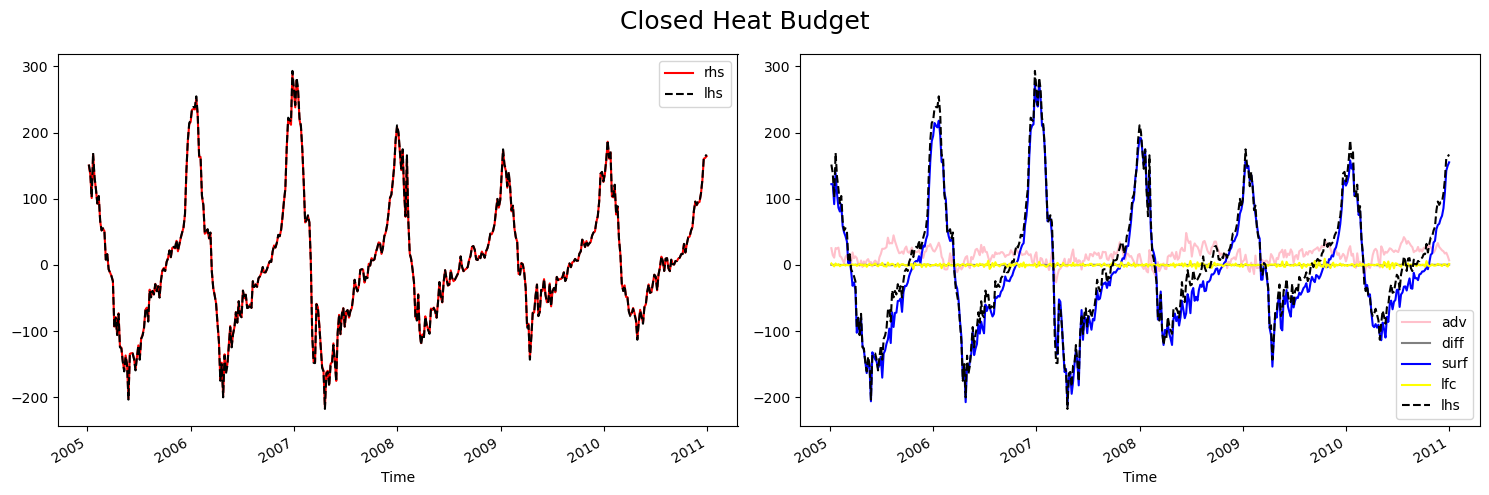

In [57]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,5))

(rhs/1e6).plot(color='r', label='rhs', ax=ax0)
(lhs/1e6).plot(color='k', linestyle='--', label='lhs', ax=ax0)
ax0.legend()

(residual_adv/1e6).plot(color='pink', label='adv', ax=ax1)
(residual_diff/1e6).plot(color='grey', label='diff', ax=ax1)
(residual_surf/1e6).plot(color='blue', label='surf', ax=ax1)
(residual_lin/1e6).plot(color='yellow', label='lfc', ax=ax1)
(lhs/1e6).plot(color='k', linestyle='--', label='lhs', ax=ax1)
ax1.legend()

plt.suptitle('Closed Heat Budget', fontsize=18)
plt.tight_layout();

# SALT BUDGET

### Advection term

In [10]:
box1 = bb.box_budget(ds.ADVx_SLT, ds.ADVy_SLT, 57, 570, 88, 125)
box2 = bb.box_budget(ds.ADVx_SLT, ds.ADVy_SLT, 36, 570, 77, 88)
box3 = bb.box_budget(ds.ADVx_SLT, ds.ADVy_SLT,5, 570, 73, 77)
box4 = bb.box_budget(ds.ADVx_SLT, ds.ADVy_SLT,0, 570, 0, 73)

residual_adv = box1 + box2 + box3 + box4

### Diffusion term

In [11]:
box1 = bb.box_budget(ds.DFxE_SLT, ds.DFyE_SLT, 57, 570, 88, 125)
box2 = bb.box_budget(ds.DFxE_SLT, ds.DFyE_SLT, 36, 570, 77, 88)
box3 = bb.box_budget(ds.DFxE_SLT, ds.DFyE_SLT, 5, 570, 73, 77)
box4 = bb.box_budget(ds.DFxE_SLT, ds.DFyE_SLT, 0, 570, 0, 73)

residual_diff = box1 + box2 + box3 + box4

### Surface term

In [13]:
#surface sflux box
runit2mass = 1.035e3 #kg/m^3

sflux = (ds.SFLUX * coords.rA) / runit2mass

box1 = sflux.isel(YC=slice(88, 125), XC=slice(57, None)).sum(dim=['XC','YC'])
box2 = sflux.isel(YC=slice(77, 88), XC=slice(36, None)).sum(dim=['XC','YC'])
box3 = sflux.isel(YC=slice(73, 77), XC=slice(5, None)).sum(dim=['XC','YC'])
box4 = sflux.isel(YC=slice(None, 73)).sum(dim=['XC','YC'])

residual_surf = box1 + box2 + box3 + box4

### Linear free surface correction term

In [14]:
#lin_fs_correction box
wsltmass = -(ds.WSLTMASS.isel(Zl=0, drop=True) * coords.rA)

box1 = wsltmass.isel(YC=slice(88, 125), XC=slice(57, None)).sum(dim=['XC','YC'])
box2 = wsltmass.isel(YC=slice(77, 88), XC=slice(36, None)).sum(dim=['XC','YC'])
box3 = wsltmass.isel(YC=slice(73, 77), XC=slice(5, None)).sum(dim=['XC','YC'])
box4 = wsltmass.isel(YC=slice(None, 73)).sum(dim=['XC','YC'])

residual_lin = box1 + box2 + box3 + box4

### Total tendency term (LHS)

In [15]:
#totstend box
totstend = ds.TOTSTEND * coords.rA * coords.drF * coords.hFacC
box1 = totstend.isel(YC=slice(88, 125), XC=slice(57, None)).sum(dim=['XC','YC', 'Z']) / (24*60*60)
box2 = totstend.isel(YC=slice(77, 88), XC=slice(36, None)).sum(dim=['XC','YC', 'Z']) / (24*60*60)
box3 = totstend.isel(YC=slice(73, 78), XC=slice(5, None)).sum(dim=['XC','YC', 'Z']) / (24*60*60)
box4 = totstend.isel(YC=slice(None, 73)).sum(dim=['XC','YC', 'Z']) / (24*60*60)

residual_tot = box1 + box2 + box3 + box4

### LHS = RHS

In [16]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.c95664fcf69d4a73a8a6170fb4e88ed2/status,


In [17]:
residual_adv.load();
residual_diff.load();
residual_lin.load();
residual_surf.load();
residual_tot.load();

In [18]:
rhs = residual_adv + residual_diff + residual_lin + residual_surf
lhs = residual_tot

In [19]:
((rhs-lhs).mean('time')/1e6).values

array(-0.00016708)

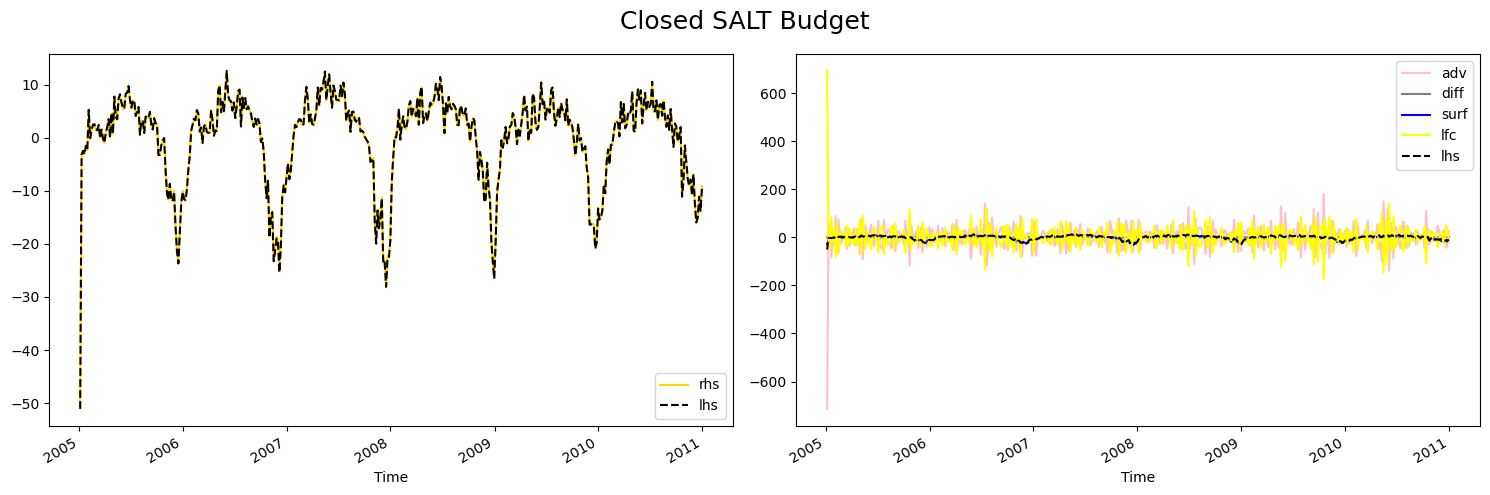

In [20]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,5))

(rhs/1e6).plot(color='gold', label='rhs', ax=ax0)
(lhs/1e6).plot(color='k', linestyle='--', label='lhs', ax=ax0)
ax0.legend()

(residual_adv/1e6).plot(color='pink', label='adv', ax=ax1)
(residual_diff/1e6).plot(color='grey', label='diff', ax=ax1)
(residual_surf/1e6).plot(color='blue', label='surf', ax=ax1)
(residual_lin/1e6).plot(color='yellow', label='lfc', ax=ax1)
(lhs/1e6).plot(color='k', linestyle='--', label='lhs', ax=ax1)
ax1.legend()

plt.suptitle('Closed SALT Budget', fontsize=18)
plt.tight_layout();